# Simple Unet Model to Segment a Single Malignancy from Mammograms

### Using TensorFlow Input Pipeline

| Class               | Grayscale Value | Color Name | RGB Value        |
|---------------------|-----------------|------------|------------------|
| `background`        | `0` - 0.              | black      | `RGB (0, 0, 0)`  |
| `malignant_mass`    | `76` - 1.            | red        | `RGB (255, 0, 0)`|
| `benign_mass`       | `149` - 2.           | green      | `RGB (0, 255, 0)`|
| `macrocalcifications` | `178` - 3.         | cyan       | `RGB (0, 255, 255)`|
| `microcalcifications` | `255` - 4.         | white      | `RGB (255, 255, 255)`|


In [1]:
# %pip install focal-loss
# %pip install segmentation_models

# only for error correction if using segmentation_models - of keras.utils
# %env SM_FRAMEWORK=tf.keras

In [1]:
# if something goes wrong with the variables - run this and clear everything
%reset -f

In [2]:
import tensorflow as tf

print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

strategy = tf.distribute.MirroredStrategy()

Number of GPUs Available:  1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random

import sys
sys.path.append('../../utils')
sys.path.append('../../models')

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

**Select Loss Function**

In [4]:
loss_functions = ['combined_jaccard_dice_loss', 'jaccard_loss', 'dice_loss', 'focal_loss', 'binary']
loss_name = loss_functions[0] 


model_names = ['simple_unet', 'simple_resunet', 'vgg_tl_unet', 'resnet_tl_resunet', 'attention_unet', 'attention_resunet']
# model_name = model_names[0]

# Number of models
num_models = len(model_names)

class_name = '_masses.png'

**Filtering Data**

In [5]:
df = pd.read_csv('../../data/raw/data_filtered.csv')
df = df[df['status'] == 'abnormal']
df.head()

,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
10,3,0003-RCC,RCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
11,3,0003-RMLO,RMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
16,5,0005-LCC,LCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
17,5,0005-LMLO,LMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
22,12,0012-LCC,LCC,abnormal,0.0,1.0,0.0,1.0,NaN,Scattered Fibroglandular Densities,NaN,NaN


In [6]:
len(df)

497

Select the Appropriate Class for Training

In [7]:
df_selected = df[(df['m_mass'] == 1.0) | (df['b_mass'] == 1.0)]

In [8]:
df_selected.head()

,patient_id,image_id,view,status,m_mass,b_mass,mic_cluster,mac,z_index,breast_density,notes,Unnamed: 11
10,3,0003-RCC,RCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
11,3,0003-RMLO,RMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
16,5,0005-LCC,LCC,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
17,5,0005-LMLO,LMLO,abnormal,0.0,1.0,0.0,0.0,NaN,Scattered Fibroglandular Densities,NaN,NaN
22,12,0012-LCC,LCC,abnormal,0.0,1.0,0.0,1.0,NaN,Scattered Fibroglandular Densities,NaN,NaN


In [9]:
len(df_selected)

418

**Prepare Filepaths**

In [10]:
# most common ratio for cropped images ----- h = 1.8 * w
# w = 1000, h = 1800
# w = 1500, h = 2700
# w = 2000, h = 3600
# most common ratio for cropped images ----- h = 1.25 * w
# w = 1000, h = 1250
# w = 1500, h = 1875
# w = 2000, h = 2500

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

# if crop is not used
# IMAGE_HEIGHT = 4096//4
# IMAGE_WIDTH = 3328//4

# if crop is used
IMAGE_HEIGHT = 3200//4
IMAGE_WIDTH = 1728//4


image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)

image_dir = '../../data/raw/abnormal/images/'
mask_dir = '../../data/raw/abnormal/masks/'

image_files = sorted([image_dir + id + '.png' for id in df_selected['image_id']])
# mask_files = sorted([mask_dir + id + '.png' for id in df_selected['image_id']])

In [ ]:
# mask_files = []

# with strategy.scope():
#     for image_id in df_selected['image_id']:
#         folder_path = os.path.join(mask_dir, image_id)
#         if os.path.isdir(folder_path):
#             mask_combined = None
#             for file in os.listdir(folder_path):
#                 if file.endswith('_mmass.png') or file.endswith('_bmass.png'):
#                     mask_path = os.path.join(folder_path, file)
#                     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    
#                     # Modify the pixel values
#                     mask[mask >= 76] = 255
                    
#                     # Combine the masks
#                     if mask_combined is None:
#                         mask_combined = mask
#                     else:
#                         mask_combined = np.maximum(mask_combined, mask)
            
#             if mask_combined is not None:
#                 combined_mask_path = os.path.join(folder_path, image_id + '_masses.png')
#                 cv2.imwrite(combined_mask_path, mask_combined)
#                 mask_files.append(combined_mask_path)

In [12]:
mask_files = []

for image_id in df['image_id']:
    folder_path = os.path.join(mask_dir, image_id)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(class_name):
                mask_files.append(os.path.join(folder_path, file))

In [13]:
logs_directory = f'../../logs/annotation_class_pixels/all_models/masses/{loss_name}/'
os.makedirs(logs_directory, exist_ok=True)
results_dir = f'../../results/annotation_class_pixels/all_models/masses/{loss_name}/'
os.makedirs(results_dir, exist_ok=True)

print(len(mask_files), len(image_files))

418 418


**Pre-processing**

In [14]:
from preprocessing import crop_breast, dilate, truncate, clahe

def preprocessing_pipeline(img, mask):
    image, mask, new_height, new_width = crop_breast(img.numpy().squeeze(), mask.numpy().squeeze())
    # image = truncate(image, lower_percentile=20, upper_percentile=100)
    # image = dilate(image, kernel_size=3, iterations=1)
    image = clahe(image, clip=1.0, gridSize=20)
    
    image = image.reshape(new_height, new_width, 1)
    mask = mask.reshape(new_height, new_width, 1)
    
    img_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
    
    return img_tensor, mask_tensor


def wrap_preprocessing(image, mask):
    processed_image, processed_mask = tf.py_function(
        preprocessing_pipeline,
        [image, mask],
        [tf.float32, tf.float32]
    )
    
    processed_image.set_shape([None, None, 1])
    processed_mask.set_shape([None, None, 1])
    
    return processed_image, processed_mask

**Data Augmentation**

In [15]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation_shared = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    # preprocessing.RandomRotation(0.1, fill_mode='constant', interpolation='nearest'),
    # preprocessing.RandomZoom(0.1, 0.1, fill_mode='constant', interpolation='nearest'),
])

data_augmentation_image_only = tf.keras.Sequential([
    preprocessing.RandomContrast(0.2),
    # Add more
])

def add_augmentation(img, mask):
    combined = tf.concat([img, mask], axis=-1)  # Stack the image and mask
    combined = data_augmentation_shared(combined)
    img, mask = tf.split(combined, [img.shape[-1], mask.shape[-1]], axis=-1)  # Split them back
    
    # Apply image-only augmentations
    img = data_augmentation_image_only(img)
    
    return img, mask


**Prepare Data**

In [16]:
############################################
# run this code if pre-processing is not involved
############################################

# def process_path(image_path, mask_path):
    
#     # Process Image
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_png(img, channels=1)

#     # Process Mask
#     mask = tf.io.read_file(mask_path)
#     mask = tf.image.decode_png(mask, channels=1)
    
#     # Normalize - run if not preprocessing
#     img = img / 255  # Normalize [0, 1]
#     mask = mask / mask_gray_value # Normalize [0, 1]
    
#     # Resize
#     img = tf.image.resize(img, image_size)
#     mask = tf.image.resize(mask, image_size, method='nearest')
    
#     mask = tf.cast(mask, tf.int32)

#     return img, mask

In [17]:
############################################
# run this code if pre-processing is involved
############################################

def process_path(image_path, mask_path, use_rgb=False):
    # Process Image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=1)

    # Process Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    # Custom Preprocessing
    img, mask = wrap_preprocessing(img, mask)
    
    # Resize
    img = tf.image.resize(img, image_size)
    mask = tf.image.resize(mask, image_size, method='nearest')
    
    # Data augmentation
    # img, mask = add_augmentation(img, mask)
    
    # Normalize
    img = img / 255  # Normalize [0, 1]
    mask = mask / 255 # Normalize [0, 1]
    
    mask = tf.cast(mask, tf.int32)
    img = tf.image.grayscale_to_rgb(img)

    return img, mask

**Train and Test Split**

In [18]:
image_files_unseen = image_files[-1]
mask_files_unseen = mask_files[-1]

image_files = image_files[:-1]
mask_files = mask_files[:-1]

In [19]:
train_images, test_images, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

In [20]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training masks: {len(train_masks)}")
print(f"Number of testing images: {len(test_images)}")
print(f"Number of testing masks: {len(test_masks)}")

Number of training images: 333
Number of training masks: 333
Number of testing images: 84
Number of testing masks: 84


**Build Data pipeline**

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

batch_size = 2
prefetch_buffer_size=tf.data.AUTOTUNE

train_dataset = train_dataset.map(process_path).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_train_data.tfrecord')
test_dataset = test_dataset.map(process_path).batch(batch_size).prefetch(prefetch_buffer_size).cache(filename='cached_test_data.tfrecord')

In [22]:
# Sanity check

for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Image batch dtype:", images.dtype)
    print("Mask batch shape:", masks.shape)
    print("Mask batch dtype:", masks.dtype)

gc.collect()    

Image batch shape: (2, 800, 432, 3)
Image batch dtype: <dtype: 'float32'>
Mask batch shape: (2, 800, 432, 1)
Mask batch dtype: <dtype: 'int32'>


0

In [23]:
# do sanity check - view image and mask randomly

def show_img_mask(dataset, batch, image_number):
    for images, masks in train_dataset.take(batch):
        
        image = images[image_number]
        mask = masks[image_number]

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(tf.squeeze(mask), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.show()

        print("Unique values in the mask:", np.unique(tf.squeeze(mask).numpy()))

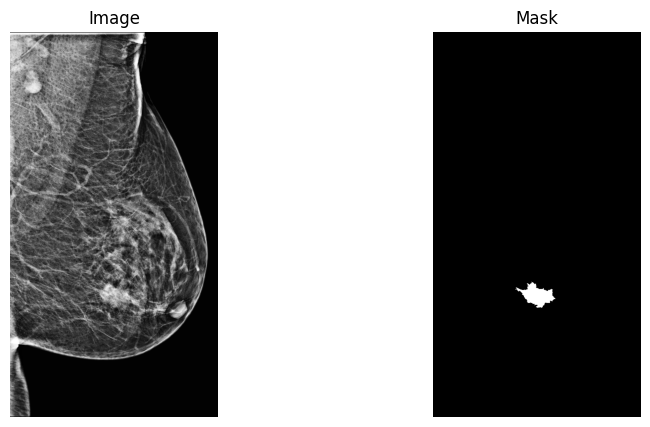

Unique values in the mask: [0 1]


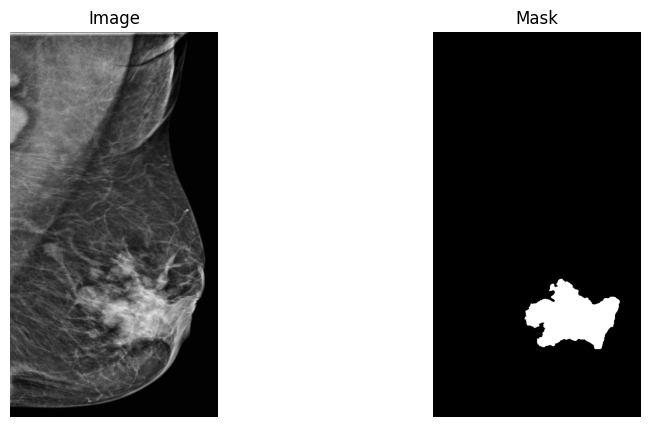

Unique values in the mask: [0 1]


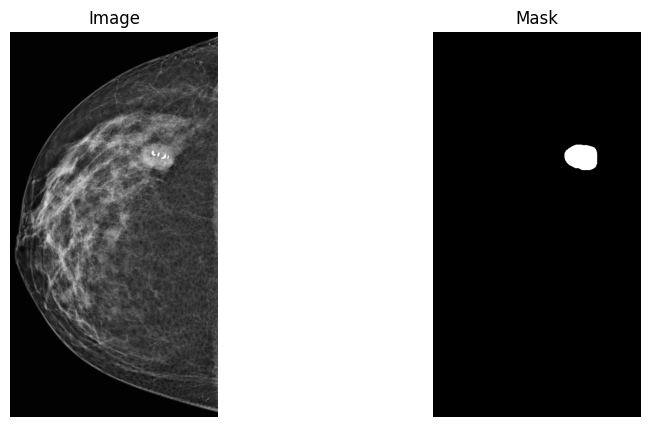

Unique values in the mask: [0 1]


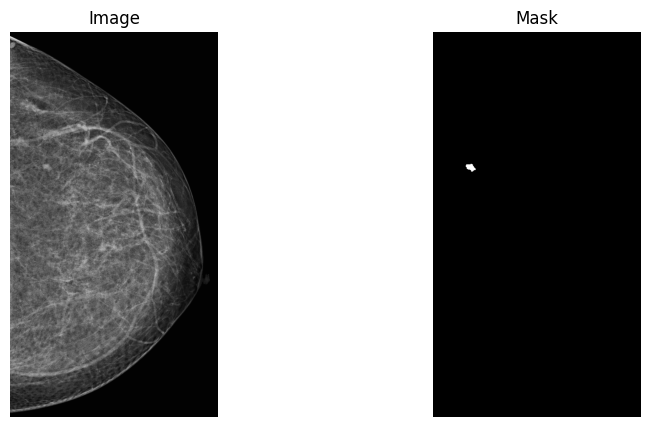

Unique values in the mask: [0 1]


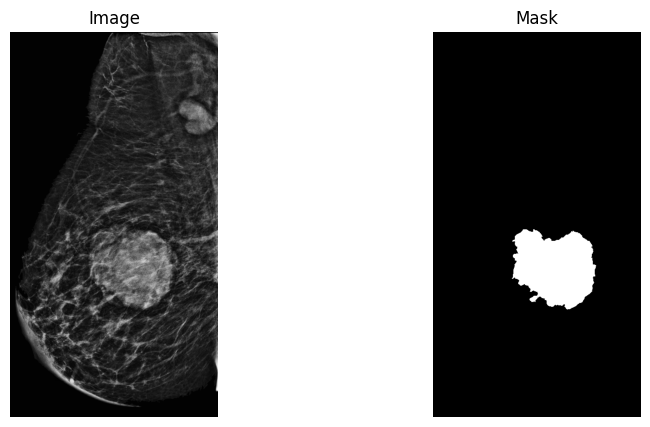

Unique values in the mask: [0 1]


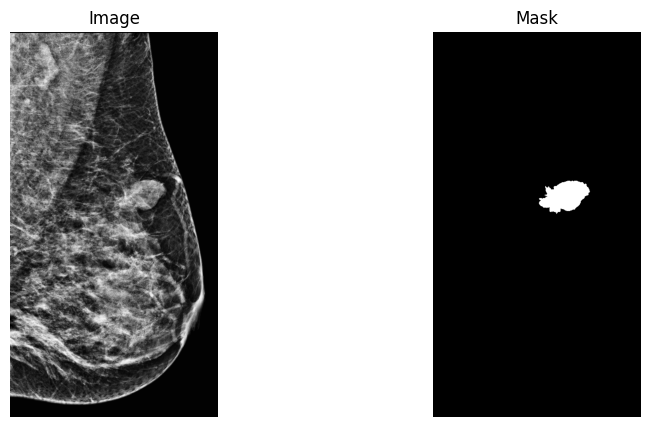

Unique values in the mask: [0 1]


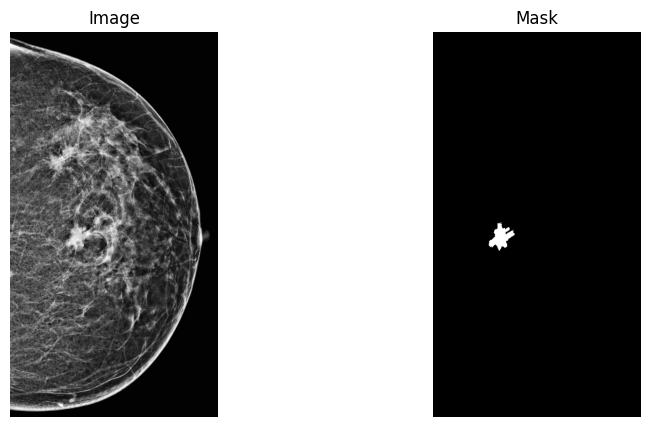

Unique values in the mask: [0 1]


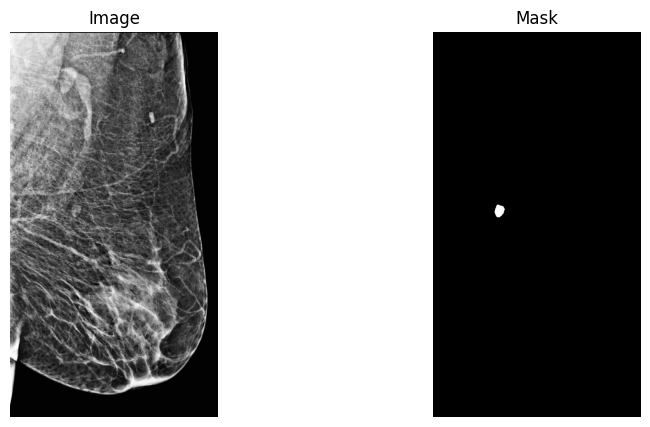

Unique values in the mask: [0 1]


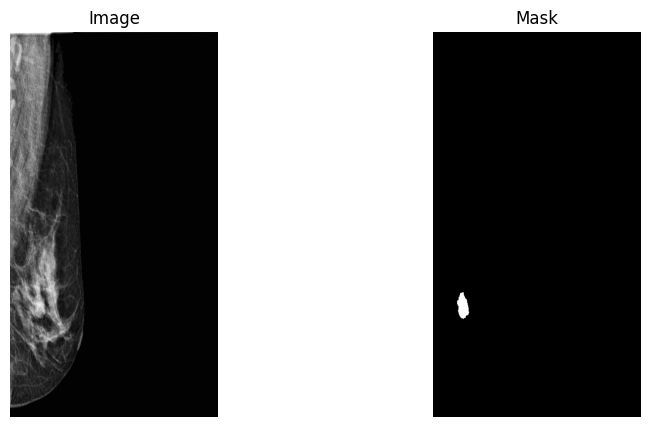

Unique values in the mask: [0 1]


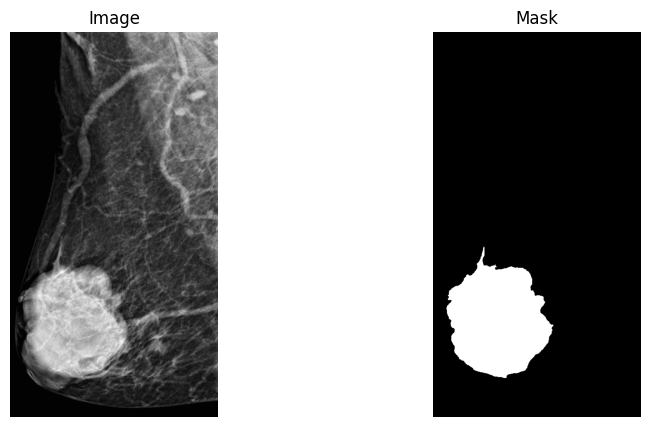

Unique values in the mask: [0 1]


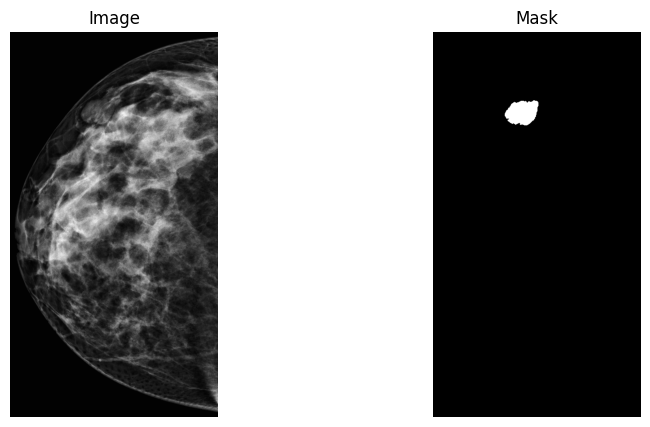

Unique values in the mask: [0 1]


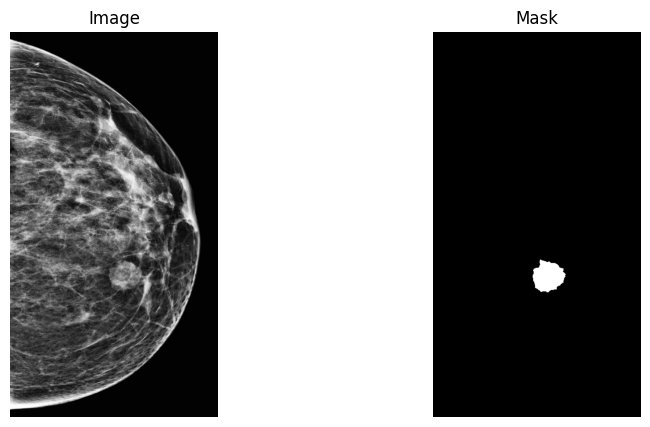

Unique values in the mask: [0 1]


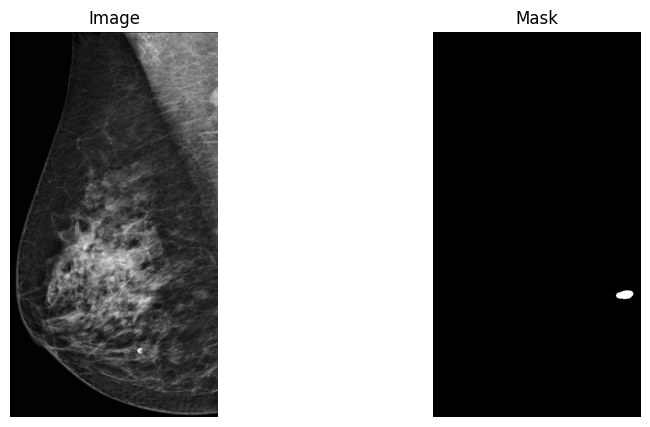

Unique values in the mask: [0 1]


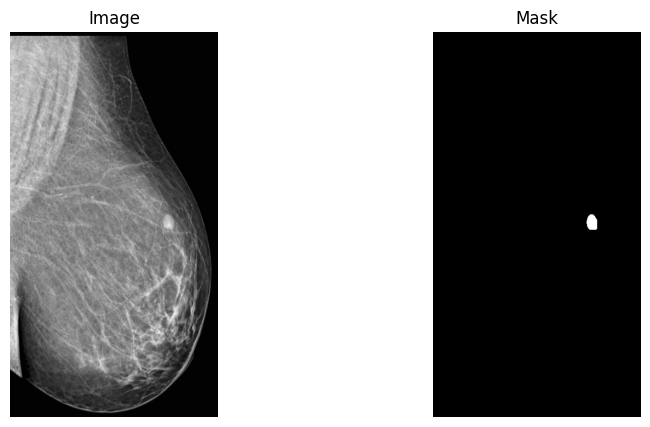

Unique values in the mask: [0 1]


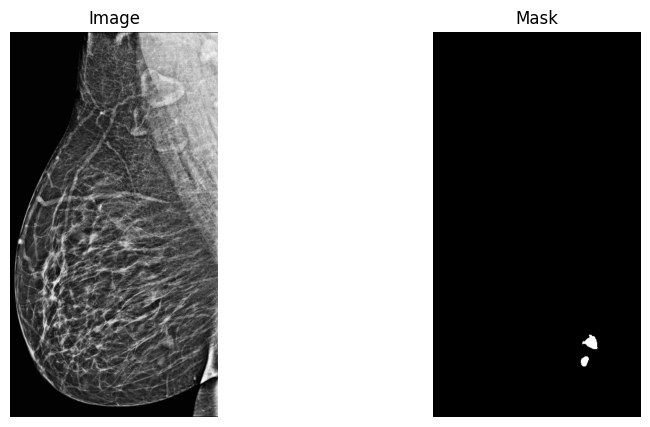

Unique values in the mask: [0 1]


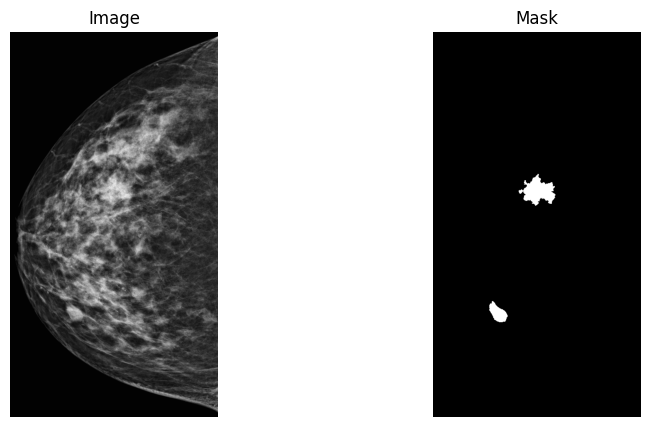

Unique values in the mask: [0 1]


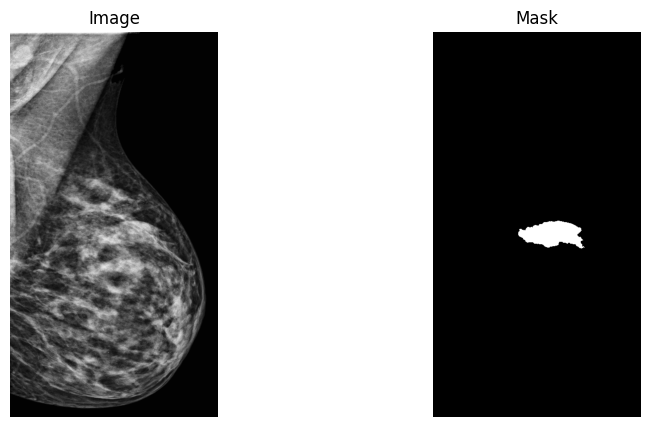

Unique values in the mask: [0 1]


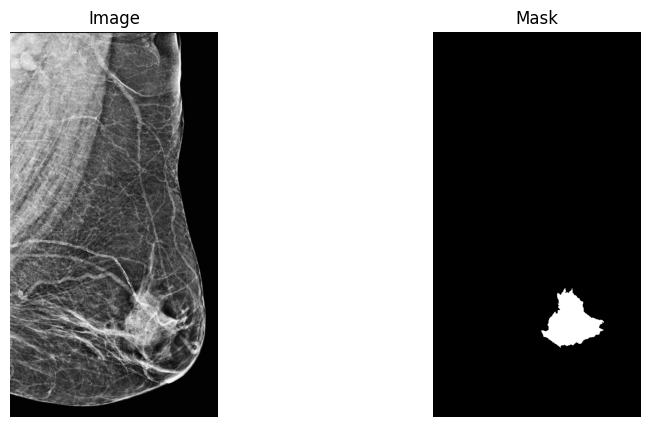

Unique values in the mask: [0 1]


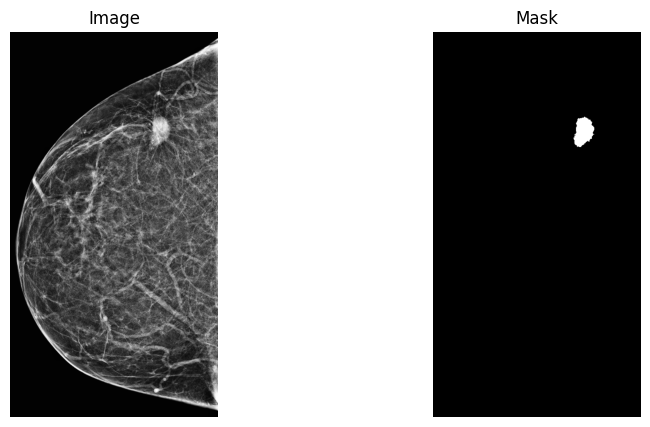

Unique values in the mask: [0 1]


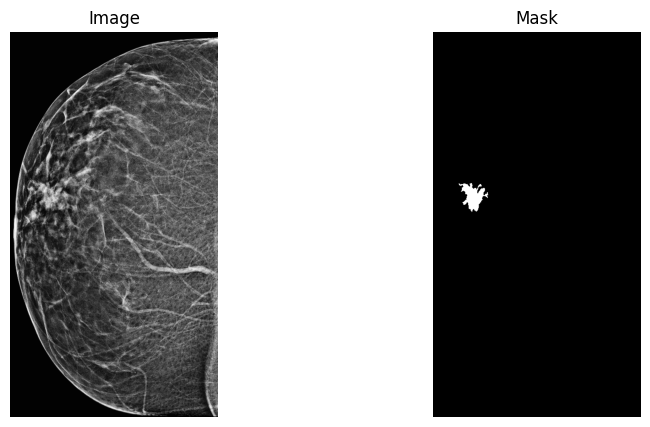

Unique values in the mask: [0 1]


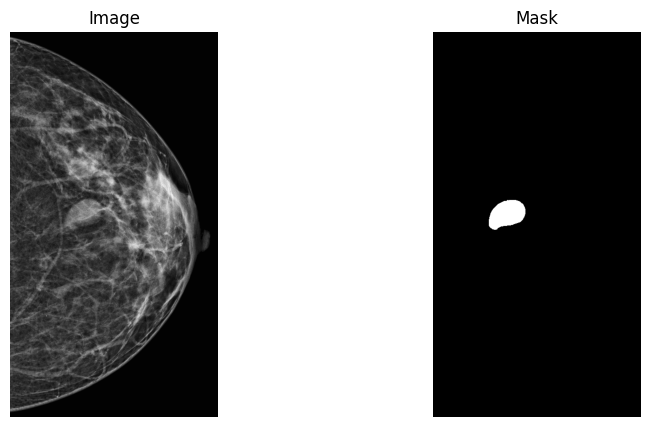

Unique values in the mask: [0 1]


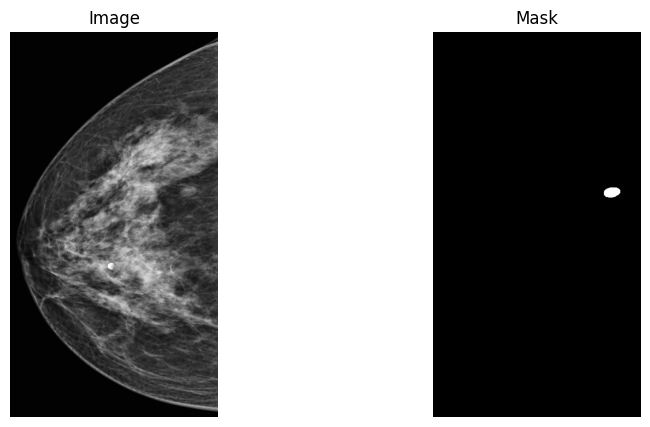

Unique values in the mask: [0 1]


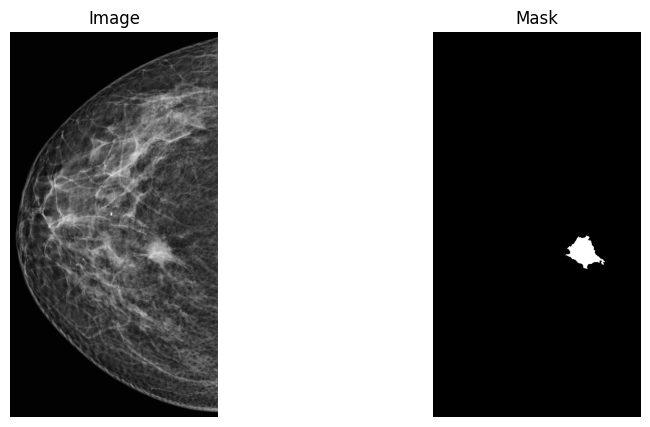

Unique values in the mask: [0 1]


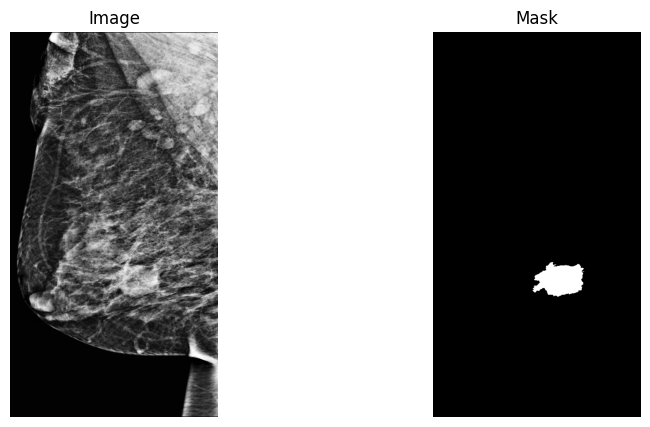

Unique values in the mask: [0 1]


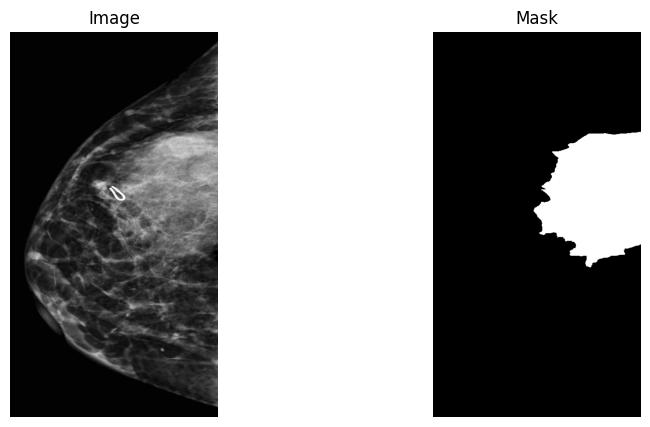

Unique values in the mask: [0 1]


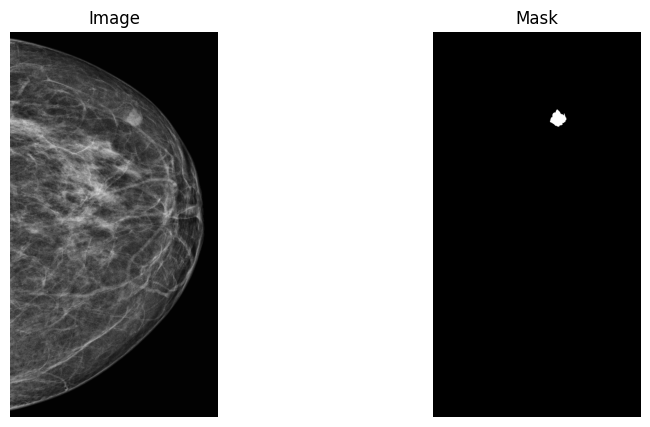

Unique values in the mask: [0 1]


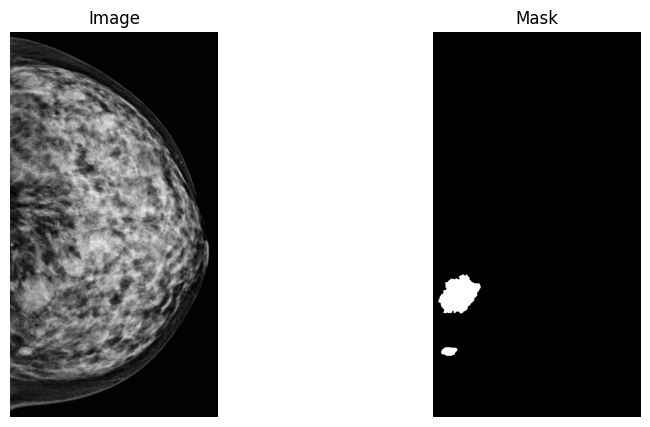

Unique values in the mask: [0 1]


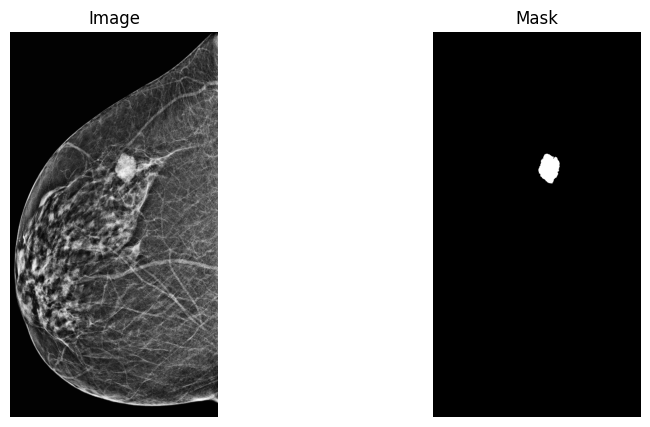

Unique values in the mask: [0 1]


In [24]:
show_img_mask(dataset=train_dataset, batch=28, image_number=1)

### **Define the Unet Model**

Simple Unet model for single-class segmentation

In [26]:
from unet_models import unet_model, res_unet_model, TL_vgg_unet_model, TL_resnet_unet_model, attention_unet_model, attention_res_unet_model

In [27]:
def get_model(model_name):
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3); num_classes=1; num_filters=8; dropout=0.1; batch_norm=True
    
    if model_name == 'simple_unet':
        return unet_model(num_classes=num_classes, input_size=input_shape, num_filters=num_filters, dropout=dropout, batch_norm=batch_norm)
    elif model_name == 'simple_resunet':
        return res_unet_model(num_classes=num_classes, input_size=input_shape, num_filters=num_filters, dropout=dropout, batch_norm=batch_norm)
    elif model_name == 'vgg_tl_unet':
        # VGG requires 3 channels
        return TL_vgg_unet_model(num_classes=num_classes, input_shape=input_shape, num_filters=num_filters, dropout=0, batch_norm=batch_norm)
    elif model_name == 'resnet_tl_resunet':
        # ResNet requires 3 channels
        return TL_resnet_unet_model(num_classes=num_classes, input_shape=input_shape, num_filters=num_filters, dropout=0, batch_norm=batch_norm)
    elif model_name == 'attention_unet':
        return attention_unet_model(num_classes=num_classes, input_size=input_shape, num_filters=num_filters, dropout=dropout, batch_norm=batch_norm)
    elif model_name == 'attention_resunet':
        return attention_res_unet_model(num_classes=num_classes, input_size=input_shape, num_filters=num_filters, dropout=dropout, batch_norm=batch_norm)
    else:
        raise ValueError("Unknown model name")

**Compile Model**

test with 
* different optimizers - adam, rmsprop, sgd
* loss functions - binary_crossentropy, iou/jaccard loss, dice loss, combined iou and dice loss, focal loss
* metrics - iou/jaccard, dice coefficient, Fscore

In [28]:
from loss_and_metrics import jaccard_coef, jaccard_loss, dice_coef, dice_loss, combined_jaccard_dice_loss, focal_loss, specificity, precision, recall, f1score

model_histories = {}

with strategy.scope():
    for model_name in model_names:
        model = get_model(model_name=model_name)
        
        ########################################## Compile Model ##########################################
        
        metrics = [f1score, specificity, jaccard_coef, dice_coef]
        if loss_name == 'combined_jaccard_dice_loss':
            loss_function = combined_jaccard_dice_loss(alpha=0.5)
        elif loss_name == 'jaccard_loss':
            loss_function = jaccard_loss
        elif loss_name == 'dice_loss':
            loss_function = dice_loss
        elif loss_name == 'focal_loss':
            loss_function = focal_loss
        elif loss_name == 'binary':
            loss_function = 'binary_crossentropy'
        else:
            raise ValueError('Invalid loss function')

        model.compile(optimizer=Adam(lr=1e-5),
                      loss=loss_function,
                      metrics=metrics)

        # model.summary()

        ########################################## Model Training ##########################################

        checkpoint_path = logs_directory + '{}_best.hdf5'.format(model_name)
        model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   save_weights_only=False, 
                                   mode='min')

        early_stopping = EarlyStopping(monitor='val_loss', 
                                    patience=7, 
                                    verbose=1, 
                                    mode='min')
        
        # If starting with pre-trained weights. 
        # model.load_weights('???.hdf5')

        epochs = 5

        history = model.fit(train_dataset, 
                            epochs=epochs, 
                            validation_data=test_dataset, 
                            verbose=1, 
                            shuffle=False,
                            callbacks=[model_checkpoint, early_stopping]
                        )
        
        model_histories[model_name] = history

        model.save(logs_directory + '{}.hdf5'.format(model_name))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

KeyboardInterrupt: 

### **Evaluations**

**Accuracy and Loss**

In [ ]:
plt.figure(figsize=(10, 8))

for model_name, history in model_histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} - Training loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} - Validation loss')

plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def plot_metrics(metric_name, model_histories):
    plt.figure(figsize=(10, 8))
    
    for model_name, history in model_histories.items():
        plt.plot(history.history[metric_name], label=f'{model_name} - Training {metric_name}')
        plt.plot(history.history[f'val_{metric_name}'], label=f'{model_name} - Validation {metric_name}')
    
    plt.title(f'Model {metric_name.capitalize()} Comparison')
    plt.ylabel(metric_name.capitalize())
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

plot_metrics('jaccard_coef', model_histories)

plot_metrics('dice_coef', model_histories)

plot_metrics('f1score', model_histories)


**Evaluate Best Model**

In [ ]:
threshold = 0.7

In [ ]:
filename = os.path.join(results_dir, 'evaluation_results.txt')

with open(filename, 'w') as file:
    for model_name in model_names:
        model_path = logs_directory + '{}_best.hdf5'.format(model_name)
        model = load_model(model_path, compile=False)
        
        loss, f1score, spec, iou, dice = model.evaluate(test_dataset)
        
        metrics = [f1score, specificity, jaccard_coef, dice_coef]
        if loss_name == 'combined_jaccard_dice_loss':
            loss_function = combined_jaccard_dice_loss(alpha=0.5)
        elif loss_name == 'jaccard_loss':
            loss_function = jaccard_loss
        elif loss_name == 'dice_loss':
            loss_function = dice_loss
        elif loss_name == 'focal_loss':
            loss_function = focal_loss
        elif loss_name == 'binary':
            loss_function = 'binary_crossentropy'
        else:
            raise ValueError('Invalid loss function')

        model.compile(optimizer=Adam(lr=1e-5),
                      loss=loss_function,
                      metrics=metrics)

        # Format the results
        content = f"""
        
        Model: {model_name}
        --------------------
        Loss: {loss:.4f}
        F1-Score: {f1score:.4f}
        Specificity: {spec:.4f}
        IoU / Jaccard Coeff: {iou:.4f}
        Dice Coeff: {dice:.4f}
        
        """

        file.write(content)
        
        print(content)

In [ ]:
models = []

for model_name in model_names:
    model_path = logs_directory + '{}_best.hdf5'.format(model_name)
    model = load_model(model_path, compile=False)
    models.append(model)

Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix_for_model(model, model_name, test_dataset, threshold, ax):
    all_true_labels = []
    all_predicted_labels = []

    for images, masks in test_dataset:
        y_pred = model.predict(images)
        y_pred = tf.cast(y_pred > threshold, tf.float32)
        y_true = tf.cast(masks, tf.float32)

        all_predicted_labels.extend(y_pred.numpy().flatten())
        all_true_labels.extend(y_true.numpy().flatten())

    cm = confusion_matrix(all_true_labels, all_predicted_labels)
        
    class_names = ['Background', 'Lesion']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    ax.set_title('Confusion Matrix for ' + model_name)
    ax.set_ylabel('Actual Class')
    ax.set_xlabel('Predicted Class')

In [ ]:
fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 4))
        
for ax, model, model_name in zip(axes, models, model_names):
    plot_confusion_matrix_for_model(model, model_name, test_dataset, threshold, ax)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
plt.show()
plt.clf()

**Average IoU Score**

In [ ]:
threshold=0.7

In [ ]:
def calculate_batch_iou(true_mask, pred_mask):
    ious = []
    
#     pred_mask = tf.math.round(pred_mask)  # convert pred probs to binary preds (0 or 1)
    pred_mask = tf.cast(pred_mask > threshold, tf.float32)
    true_mask = tf.cast(true_mask, tf.float32)

    intersection = tf.math.logical_and(tf.cast(true_mask, tf.bool), tf.cast(pred_mask, tf.bool))
    union = tf.math.logical_or(tf.cast(true_mask, tf.bool), tf.cast(pred_mask, tf.bool))
    iou = tf.reduce_sum(tf.cast(intersection, tf.float32)) / tf.reduce_sum(tf.cast(union, tf.float32))
    ious.append(iou)

    return tf.stack(ious)

In [ ]:
for model, model_name in zip(models, model_names):
    total_iou = 0.0
    total_batches = 0
    for images, masks in test_dataset:
        preds = model.predict(images)
        batch_iou = calculate_batch_iou(masks, preds)
        total_iou += batch_iou
        total_batches += 1

    mean_iou = total_iou / total_batches
    mean_iou_content = f"Mean IoU for {model_name} = {mean_iou.numpy()}"

    print(mean_iou_content)
    with open(filename, 'a') as file:
        file.write('\n' + mean_iou_content)

print(f"Mean IoU has been added to: {filename}")

## **Predictions**

**Predict on Test Image**

In [ ]:
def check_predictions_for_all_models(dataset, batch, img, models, model_names, threshold, results_dir):
    for images, masks in dataset.take(batch):
        plt.figure(figsize=(15 + 5 * len(models), 5))
        
        # plot original image
        plt.subplot(1, len(models) + 2, 1)
        plt.imshow(images[img])
        plt.title("Original Image")
        
        # plot ground truth mask
        plt.subplot(1, len(models) + 2, 2)
        true_masks = tf.cast(masks, tf.float32)
        plt.imshow(true_masks[img], cmap='jet')
        plt.title("Ground Truth")
        
        # loop through each model and plot predictions
        for i, (model, model_name) in enumerate(zip(models, model_names), start=3):
            predicted_masks = model.predict(images)
            predicted_masks = tf.cast(predicted_masks > threshold, tf.float32)
            
            iou = calculate_batch_iou(true_masks[img], predicted_masks[img])
            
            plt.subplot(1, len(models) + 2, i)
            plt.imshow(predicted_masks[img], cmap='jet')
            plt.title(f"{model_name} IoU: {iou:.3f}")
        
        plt.savefig(os.path.join(results_dir, 'predictions_comparison.png'))
        plt.show()
        plt.clf()


check_predictions_for_all_models(dataset=test_dataset, batch=2, img=3, models=models, model_names=model_names, threshold=threshold, results_dir=results_dir)


**Predict on Unseen Data**

In [ ]:
def predict_single_image_masks(models, model_names, image_path, mask_path, image_size, mask_gray_value, threshold, results_dir):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    image, mask = wrap_preprocessing(image, mask)  
    image = tf.image.resize(image, image_size)
    image = image / 255
    mask = tf.image.resize(mask, image_size, method='nearest')
    mask = tf.math.round(mask / mask_gray_value)
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)
    
    plt.figure(figsize=(15 + 5 * len(models), 5))
    plt.subplot(1, len(models) + 2, 1)
    plt.imshow(image[0, :, :, 0], cmap='gray') # Assuming image is grayscale
    plt.title("Original Image")

    plt.subplot(1, len(models) + 2, 2)
    plt.imshow(mask[0, :, :, 0], cmap='jet') # Assuming mask is single-channel
    plt.title("Ground Truth")

    for i, (model, model_name) in enumerate(zip(models, model_names), start=3):
        predicted_mask = model.predict(image)
        predicted_mask = tf.cast(predicted_mask > threshold, tf.float32)
        iou = calculate_batch_iou(mask, predicted_mask)

        plt.subplot(1, len(models) + 2, i)
        plt.imshow(predicted_mask[0, :, :, 0], cmap='jet')
        plt.title(f"{model_name} - IoU: {iou:.3f}")
    
    plt.savefig(os.path.join(results_dir, 'predictions_comparison.png'))
    plt.show()
    plt.clf()
    

predict_single_image_masks(models, model_names, image_files_unseen, mask_files_unseen, image_size, mask_gray_value, threshold, results_dir)

In [ ]:
# def predict_single_image(model, image_path):
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_image(image, channels=1)
#     image, _ = wrap_preprocessing(image, np.zeros(image.shape))
#     image = tf.image.resize(image, image_size)
#     image = image / 255
    
#     image = tf.expand_dims(image, axis=0)
    
#     predicted_mask = model.predict(image)
    
#     predicted_mask = tf.math.round(predicted_mask)
    
#     plt.figure(figsize=(10, 5))
#     plt.subplot(121)
#     plt.imshow(image[0])
#     plt.title("Original Image")
    
#     plt.subplot(122)
#     plt.imshow(predicted_mask[0], cmap='jet')
#     plt.title("Predicted Image")
    
#     plt.show()

# image_path = '/kaggle/input/unseen/0248-LCC.png'
# predict_single_image(model, image_path)